In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier, LazyRegressor

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

import optuna
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from collections import defaultdict
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix)

import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)
pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [2]:
import optuna
from collections import defaultdict
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import hdbscan

In [3]:
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [12]:
selected_data = help_tool.csv_download(r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')
# selected_data.drop(columns=[
#     'OCCUPATION_TYPE', 'OWN_CAR_AGE'
#     ], inplace=True)

In [13]:
selected_data.columns

Index(['EXT_SOURCE_1', 'NAME_EDUCATION_TYPE', 'AMT_CREDIT',
       'MAX(df.DURATION_DUE_VERSION)', 'YEARS_EMPLOYED', 'EXT_SOURCE_3',
       'YEARS_BIRTH', 'MAX(df.DURATION_DECISION_DRAWING)', 'EXT_SOURCE_2',
       'MIN(df.RATIO_GOODS_PRICE_CREDIT)', 'AVG_Risk_Score',
       'MIN(df.DURATION_DECISION_DRAWING)', 'CODE_GENDER_F', 'TARGET'],
      dtype='object')

In [14]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

# Bucketing

selected_data['YEARS_BIRTH'] = help_tool.bucket_age_feature(selected_data, 'YEARS_BIRTH')
for feature in [
    'YEARS_EMPLOYED', #'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE', 'SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 
    #'AMT_INCOME_TOTAL', 
    'AMT_CREDIT'
    #, 'REGION_POPULATION_RELATIVE'
                ]:
    selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 5)

# for feature in ['Cluster_pos_cash_1']:
#     selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 3)

# for feature in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
#     selected_data[feature] = help_tool.equal_frequency_bucketing(selected_data, feature, 10)


# Null values

In [16]:
selected_data.isna().sum()

EXT_SOURCE_1                         173378
NAME_EDUCATION_TYPE                       0
AMT_CREDIT                                0
MAX(df.DURATION_DUE_VERSION)          17751
YEARS_EMPLOYED                        55374
EXT_SOURCE_3                          60965
YEARS_BIRTH                               0
MAX(df.DURATION_DECISION_DRAWING)     17751
EXT_SOURCE_2                            660
MIN(df.RATIO_GOODS_PRICE_CREDIT)      17438
AVG_Risk_Score                        18945
MIN(df.DURATION_DECISION_DRAWING)     17751
CODE_GENDER_F                             4
TARGET                                    0
dtype: int64

# TARGET
Dummy model will be found via Lazypredict. But Lazypredict doesn't have build in weights. Instead, downsampled data will be provided.

In [18]:
selected_data_target = selected_data.sample(10000, random_state=42)
selected_data_target.drop_duplicates(inplace=True)

X = selected_data_target.drop(columns=['TARGET'])
y = selected_data_target['TARGET']

class_weights = y.value_counts(normalize=True)
sample_weights = np.where(y == 0, 1 / class_weights[0], 1 / class_weights[1])

(X_train, X_validation, y_train, y_validation, 
 sample_weights_train, sample_weights_validation) = train_test_split(
    X, y, sample_weights, test_size=0.3, random_state=42, stratify=y)

In [20]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
classif_models, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

 97%|█████████▋| 28/29 [00:20<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 578, number of negative: 6422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1921
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082571 -> initscore=-2.407911
[LightGBM] [Info] Start training from score -2.407911


100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


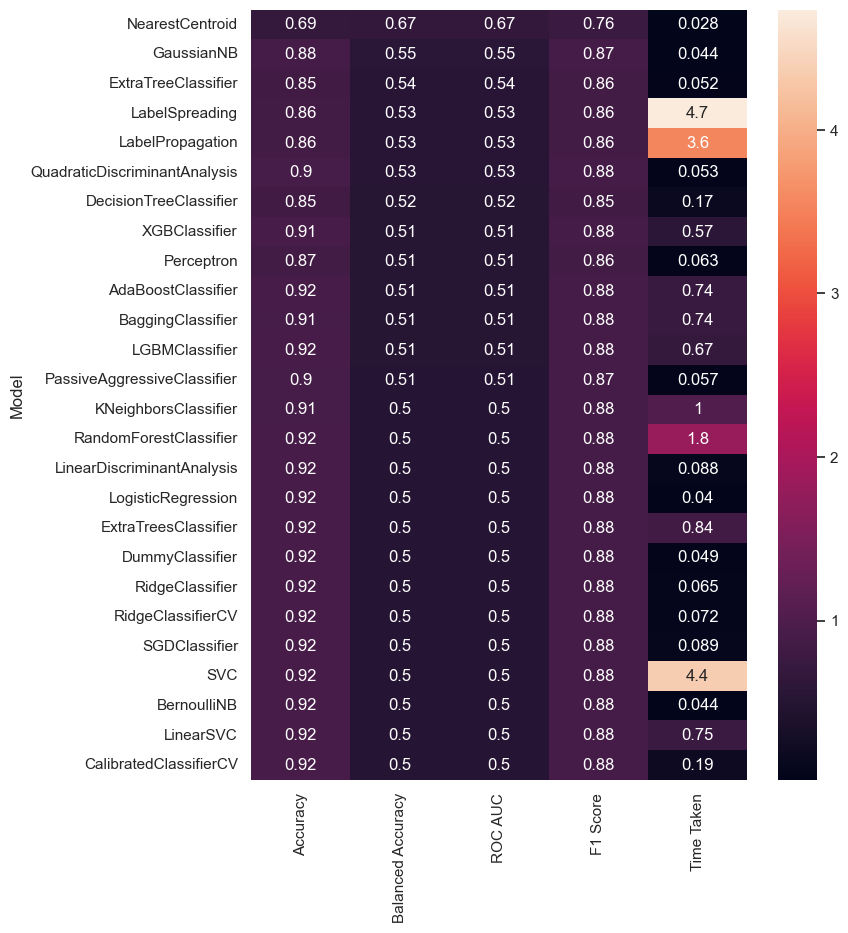

In [21]:
plt.figure(figsize=(8, 10))

sns.heatmap(classif_models[(classif_models['Time Taken'] < 10)], annot=True)
plt.show()

GaussianNB and DecissionTree.

# Model Tuning
Selected models will be hyper parameter and threshold tuned

## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and RandomizedSearchCV. Different models require different data preparation (i.e. Logistic Regression and KNN requires scaling, while Tree based models require sorting), but because a Pipeline is used, all models are being fed the same StandardScaled data.

After best parameters and models are storred in memory.

In [208]:
# import optuna
# from lightgbm.sklearn import LGBMClassifier
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import f1_score, make_scorer
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [22]:
def objective(trial):
    params = {
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-1, 5),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-1, 5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e2)
    }

    if trial.suggest_categorical('class_weight', ['balanced', None]) == 'balanced':
        params['class_weight'] = 'balanced'
    
    
    # Initialize LGBMClassifier with current parameters
    model = LGBMClassifier(**params, random_state=42, verbose=-1)
    
    # Define F1 score as scoring metric for cross-validation
    scorer = make_scorer(f1_score)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)
    
    # Calculate mean F1 score across folds
    mean_f1 = cv_scores.mean()
    
    # Return the negative mean F1 score (since Optuna minimizes)
    return (1.0 - mean_f1)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best trial:')
best_trial = study.best_trial
print(f'  Value (Mean F1): {1.0 - best_trial.value:.4f}')
print('  Params:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')


Best trial:
  Value (Mean F1): 0.2803
  Params:
    lambda_l1: 0.5070118029015516
    lambda_l2: 0.3861635591244833
    num_leaves: 32
    learning_rate: 0.0026643493934382528
    feature_fraction: 0.6157714167717169
    bagging_fraction: 0.4605817717628246
    bagging_freq: 2
    min_child_samples: 52
    min_child_weight: 0.00022377436932728145
    class_weight: balanced


In [23]:
best_params = best_trial.params

# Define preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


pipeline = Pipeline(steps=[
    ('scaler', numeric_transformer),
    ('classifier', LGBMClassifier(**best_params, verbose=-1))
])


# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


# Predict on test data
y_pred_train = pipeline.predict(X_train)
y_pred_validation = pipeline.predict(X_validation)

print(f'F1 Score in Training: {f1_score(y_train, y_pred_train):.4f}')
print(f'F1 Score in Validation: {f1_score(y_validation, y_pred_validation):.4f}')


F1 Score in Training: 0.3712
F1 Score in Validation: 0.2681


## Threshold Tuning
After finding the best Hyperparameters, Optimal Thresholds will be found and stored in a dataframe.

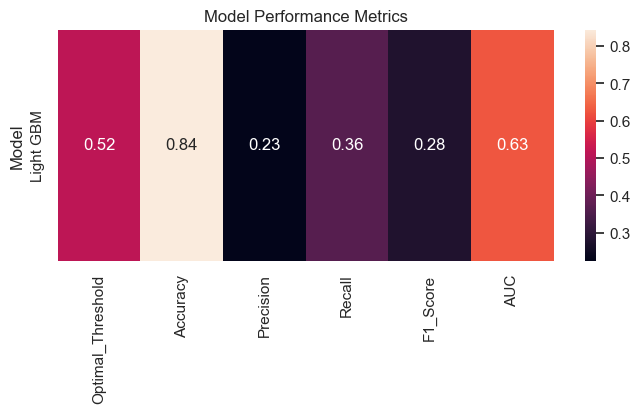

In [24]:
# Create thresholds for decision threshold tuning
thresholds = np.linspace(0, 1, 100)

# Initialize variables to track best accuracy and threshold
best_accuracy = 0
optimal_threshold = 0

y_proba = help_tool.predict_proba_available(pipeline, X_validation)

# Find optimal threshold based on accuracy
for threshold in thresholds:
    y_pred = (y_proba > threshold).astype(int)
    f1 = f1_score(y_validation, y_pred)

    if f1 > best_accuracy:
        best_accuracy = f1
        optimal_threshold = threshold

# Use the optimal threshold to predict final labels
y_pred_optimal = (y_proba > optimal_threshold).astype(int)


results = []
results.append({'Model': 'Light GBM',
                'Optimal_Threshold': optimal_threshold,
                'Accuracy': accuracy_score(y_validation, y_pred_optimal),
                'Precision': precision_score(y_validation, y_pred_optimal),
                'Recall': recall_score(y_validation, y_pred_optimal),
                'F1_Score': f1_score(y_validation, y_pred_optimal),
                'AUC': roc_auc_score(y_validation, y_pred_optimal)
                })

model_threshol_search = pd.DataFrame(results)

plt.figure(figsize=(8, 3))
sns.heatmap(model_threshol_search.set_index(
    'Model'), annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()

In [25]:
model_threshol_search['Optimal_Threshold'][0]

0.5151515151515152

In [27]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold

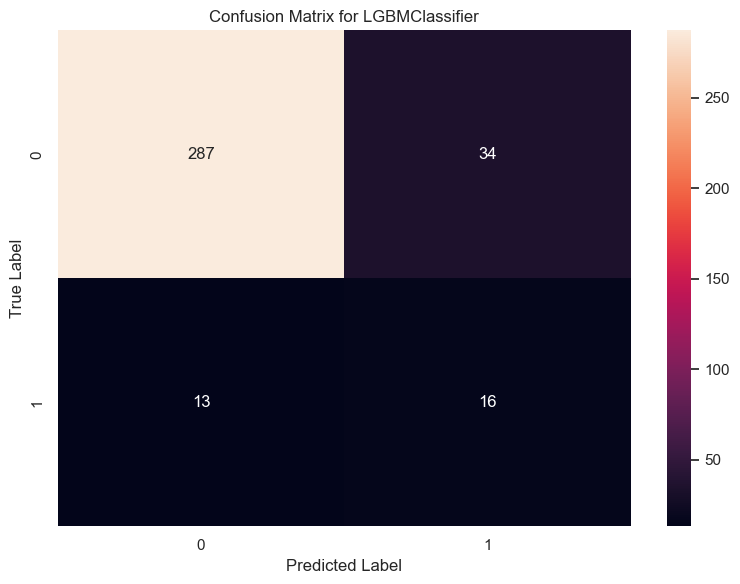

In [28]:

def cross_val_metrics(fold, X, y, pipeline):
    """ Perform cross validation with pre-fitted pipeline and calculate metrics """
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)

    # Initialize lists to store metric scores and confusion matrices
    metric_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    confusion_matrices = np.zeros((2, 2))

    for train_index, val_index in kf.split(X):
        X_train_i, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train_i, y_val = y.iloc[train_index], y.iloc[val_index]

        # Predict using pre-fitted pipeline
        y_pred = pipeline.predict(X_val)

        # Threshold update
        scores = help_tool.predict_proba_available(pipeline, X_val)

        optimal_threshold = model_threshol_search['Optimal_Threshold'][0]
        y_pred = (scores > optimal_threshold).astype(int)

        # Calculate metrics
        metric_scores['accuracy'].append(accuracy_score(y_val, y_pred))
        metric_scores['precision'].append(precision_score(y_val, y_pred))
        metric_scores['recall'].append(recall_score(y_val, y_pred))
        metric_scores['f1'].append(f1_score(y_val, y_pred))

        # Compute confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices += cm

    # Calculate average scores
    avg_metric_scores = {metric: np.mean(scores) for metric, scores in metric_scores.items()}
    avg_confusion_matrix = confusion_matrices / fold

    # Construct results dataframe
    model_info = pd.DataFrame({
        'Classifier': pipeline.named_steps['classifier'].__class__.__name__,
        'CV Mean Accuracy': np.mean(avg_metric_scores['accuracy']),
        'CV Mean Precision': np.mean(avg_metric_scores['precision']),
        'CV Mean Recall': np.mean(avg_metric_scores['recall']),
        'CV Mean F1': np.mean(avg_metric_scores['f1']),
        'Confusion Matrix': [avg_confusion_matrix]
    })

    return model_info


# Perform cross-validation with the pre-fitted pipeline
model_info = cross_val_metrics(fold=20, X=X_train, y=y_train, pipeline=pipeline)

help_tool.plot_single_confusion_matrix(model_info)

# EXT_SOURCE_1
Notebook 4 had a feature importance check, in which top most important features were found - ['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'EXT_SOURCE_3']. These features will be attempted at imputation.
## HDB SCAN
HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is an extension of DBSCAN. It finds clusters of varying densities and handles noise more effectively. 

In [32]:
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.datasets import make_blobs

In [37]:
import polars as pl

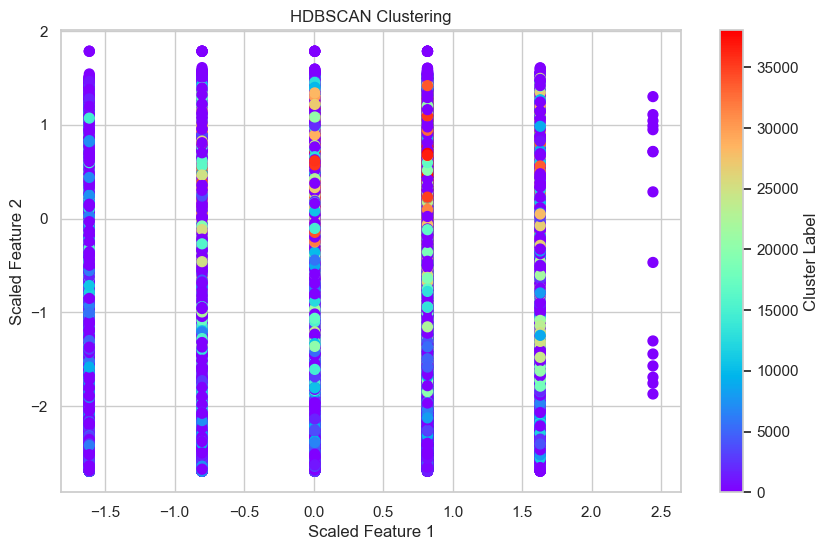

        EXT_SOURCE_1  NAME_EDUCATION_TYPE  AMT_CREDIT  \
0               0.27                    2        1.00   
1               0.82                    2        3.00   
2                NaN                    4        2.00   
3               0.72                    2        4.00   
4               0.79                    2        2.00   
...              ...                  ...         ...   
307506          0.75                    2        1.00   
307507           NaN                    2        4.00   
307508           NaN                    2        5.00   
307509           NaN                    2        5.00   
307510          0.82                    2        4.00   

        MAX(df.DURATION_DUE_VERSION)  YEARS_EMPLOYED  EXT_SOURCE_3  \
0                               0.00            3.00          0.52   
1                               0.00            5.00          0.61   
2                             210.00            5.00          0.85   
3                               0.0

In [39]:
# Convert the data to a polars DataFrame
selected_data_pl = pl.DataFrame(selected_data)

# Select relevant columns
X_pl = selected_data_pl.select(['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'EXT_SOURCE_3', 'NAME_EDUCATION_TYPE'])

# Convert to pandas DataFrame for StandardScaler and HDBSCAN
X_pd = X_pl.to_pandas()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pd)

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
cluster_labels = clusterer.fit_predict(X_scaled)

# Add cluster labels as a new feature to the polars DataFrame
selected_data_pl = selected_data_pl.with_columns(pl.Series('HDBSCAN_Cluster', cluster_labels))

# Convert back to pandas DataFrame
selected_data_pd = selected_data_pl.to_pandas()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='rainbow', s=50)
plt.title('HDBSCAN Clustering')
plt.xlabel('Scaled Feature 1')
plt.ylabel('Scaled Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Display the resulting DataFrame
print(selected_data_pd)

In [41]:
for cluster in np.unique(cluster_labels):
    if cluster != -1:  # Exclude noise points labeled as -1
        cluster_mask = selected_data_pd['HDBSCAN_Cluster'] == cluster
        mean_value = selected_data_pd.loc[cluster_mask, 'EXT_SOURCE_1'].mean()
        selected_data_pd.loc[cluster_mask & selected_data_pd['EXT_SOURCE_1'].isna(), 'EXT_SOURCE_1'] = mean_value

# Drop the HDBSCAN_Cluster column if not needed
selected_data_pd = selected_data_pd.drop(columns=['HDBSCAN_Cluster'])

# Convert back to polars DataFrame
selected_data_pl = pl.DataFrame(selected_data_pd)

# Display the resulting DataFrame
print(selected_data_pl)

shape: (307_511, 14)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ EXT_SOURCE ┆ NAME_EDUCA ┆ AMT_CREDI ┆ MAX(df.DU ┆ … ┆ AVG_Risk_ ┆ MIN(df.DU ┆ CODE_GEND ┆ TARGET │
│ _1         ┆ TION_TYPE  ┆ T         ┆ RATION_DU ┆   ┆ Score     ┆ RATION_DE ┆ ER_F      ┆ ---    │
│ ---        ┆ ---        ┆ ---       ┆ E_VERSION ┆   ┆ ---       ┆ CISION_DR ┆ ---       ┆ i64    │
│ f64        ┆ i64        ┆ f64       ┆ )         ┆   ┆ f64       ┆ AWI…      ┆ f64       ┆        │
│            ┆            ┆           ┆ ---       ┆   ┆           ┆ ---       ┆           ┆        │
│            ┆            ┆           ┆ f64       ┆   ┆           ┆ f64       ┆           ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ 0.274852   ┆ 2          ┆ 1.0       ┆ 0.0       ┆ … ┆ 1.25      ┆ 1.0       ┆ 1.0       ┆ 0      │
│ 0.817352   ┆ 2          ┆ 3.0       ┆ 0.0       ┆ … ┆ 2.0       ┆ 36

In [46]:
selected_data_pl.to_pandas().isna().sum()

EXT_SOURCE_1                         87029
NAME_EDUCATION_TYPE                      0
AMT_CREDIT                               0
MAX(df.DURATION_DUE_VERSION)         17751
YEARS_EMPLOYED                       55374
EXT_SOURCE_3                         60965
YEARS_BIRTH                              0
MAX(df.DURATION_DECISION_DRAWING)    17751
EXT_SOURCE_2                           660
MIN(df.RATIO_GOODS_PRICE_CREDIT)     17438
AVG_Risk_Score                       18945
MIN(df.DURATION_DECISION_DRAWING)    17751
CODE_GENDER_F                            4
TARGET                                   0
dtype: int64

In [40]:
selected_data_pd.head()

,EXT_SOURCE_1,NAME_EDUCATION_TYPE,AMT_CREDIT,MAX(df.DURATION_DUE_VERSION),YEARS_EMPLOYED,EXT_SOURCE_3,YEARS_BIRTH,MAX(df.DURATION_DECISION_DRAWING),EXT_SOURCE_2,MIN(df.RATIO_GOODS_PRICE_CREDIT),AVG_Risk_Score,MIN(df.DURATION_DECISION_DRAWING),CODE_GENDER_F,TARGET,HDBSCAN_Cluster
0,0.27,2,1.00,0.00,3.00,0.52,20.00,366978.00,0.64,0.78,1.25,1.00,1.00,0,15467
1,0.82,2,3.00,0.00,5.00,0.61,50.00,365619.00,0.60,1.01,2.00,365619.00,1.00,0,-1
2,NaN,4,2.00,210.00,5.00,0.85,60.00,366712.00,0.56,0.92,1.00,365968.00,1.00,0,-1
3,0.72,2,4.00,0.00,2.00,0.56,50.00,368153.00,0.50,1.00,3.00,4.00,1.00,0,30918
4,0.79,2,2.00,364539.00,5.00,0.51,50.00,367288.00,0.73,0.92,1.83,365619.00,1.00,0,35804


In [47]:
selected_data_pl = pl.DataFrame(selected_data)

# Select relevant columns
X_pl = selected_data_pl.select(['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'EXT_SOURCE_3'])

# Convert to pandas DataFrame for StandardScaler and HDBSCAN
X_pd = X_pl.to_pandas()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pd)

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
cluster_labels = clusterer.fit_predict(X_scaled)

# Convert polars DataFrame to pandas to facilitate imputation
selected_data_pd = selected_data_pl.to_pandas()
selected_data_pd['HDBSCAN_Cluster'] = cluster_labels

# Impute missing values in EXT_SOURCE_1 based on cluster means
for cluster in np.unique(cluster_labels):
    if cluster != -1:  # Exclude noise points labeled as -1
        cluster_mask = selected_data_pd['HDBSCAN_Cluster'] == cluster
        mean_value = selected_data_pd.loc[cluster_mask, 'EXT_SOURCE_1'].mean()
        selected_data_pd.loc[cluster_mask & selected_data_pd['EXT_SOURCE_1'].isna(), 'EXT_SOURCE_1'] = mean_value

# Drop the HDBSCAN_Cluster column if not needed
selected_data_pd = selected_data_pd.drop(columns=['HDBSCAN_Cluster'])

# Convert back to polars DataFrame
selected_data_pl = pl.DataFrame(selected_data_pd)

# Display the resulting DataFrame
print(selected_data_pl)


shape: (307_511, 14)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ EXT_SOURCE ┆ NAME_EDUCA ┆ AMT_CREDI ┆ MAX(df.DU ┆ … ┆ AVG_Risk_ ┆ MIN(df.DU ┆ CODE_GEND ┆ TARGET │
│ _1         ┆ TION_TYPE  ┆ T         ┆ RATION_DU ┆   ┆ Score     ┆ RATION_DE ┆ ER_F      ┆ ---    │
│ ---        ┆ ---        ┆ ---       ┆ E_VERSION ┆   ┆ ---       ┆ CISION_DR ┆ ---       ┆ i64    │
│ f64        ┆ i64        ┆ f64       ┆ )         ┆   ┆ f64       ┆ AWI…      ┆ f64       ┆        │
│            ┆            ┆           ┆ ---       ┆   ┆           ┆ ---       ┆           ┆        │
│            ┆            ┆           ┆ f64       ┆   ┆           ┆ f64       ┆           ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ 0.274852   ┆ 2          ┆ 1.0       ┆ 0.0       ┆ … ┆ 1.25      ┆ 1.0       ┆ 1.0       ┆ 0      │
│ 0.817352   ┆ 2          ┆ 3.0       ┆ 0.0       ┆ … ┆ 2.0       ┆ 36

In [49]:
selected_data_pl.to_pandas().isna().sum()

EXT_SOURCE_1                         85389
NAME_EDUCATION_TYPE                      0
AMT_CREDIT                               0
MAX(df.DURATION_DUE_VERSION)         17751
YEARS_EMPLOYED                       55374
EXT_SOURCE_3                         60965
YEARS_BIRTH                              0
MAX(df.DURATION_DECISION_DRAWING)    17751
EXT_SOURCE_2                           660
MIN(df.RATIO_GOODS_PRICE_CREDIT)     17438
AVG_Risk_Score                       18945
MIN(df.DURATION_DECISION_DRAWING)    17751
CODE_GENDER_F                            4
TARGET                                   0
dtype: int64

In [35]:
X = selected_data[['YEARS_BIRTH', 'EXT_SOURCE_2', 'CODE_GENDER_F', 'EXT_SOURCE_3', 'NAME_EDUCATION_TYPE']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
cluster_labels = clusterer.fit_predict(X_scaled)

# Add cluster labels as a new feature
selected_data['HDBSCAN_Cluster'] = cluster_labels

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='rainbow', s=50)
plt.title('HDBSCAN Clustering')
plt.xlabel('Scaled Feature 1')
plt.ylabel('Scaled Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Display the resulting DataFrame
print(selected_data)


KeyboardInterrupt: 

# Model explanability
LightGBM was chosen for explainability, as it had the best scores out of all of the models. Sub-sample of 100 is used instead of the whole set, for time saving.

In [231]:
pipeline.named_steps['classifier']#.__class__.__name__,

LGBMClassifier(bagging_fraction=0.40004943270279303, bagging_freq=6,
               class_weight='balanced', feature_fraction=0.7368049872689042,
               lambda_l1=0.7485756510326381, lambda_l2=3.441242626275538,
               learning_rate=0.03137025597467822, min_child_samples=24,
               min_child_weight=0.0003941877864049729, num_leaves=41,
               verbose=-1)

In [224]:
explainer = shap.Explainer(classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(X_validation)

In [225]:
shap_values = explainer.shap_values(X_validation)

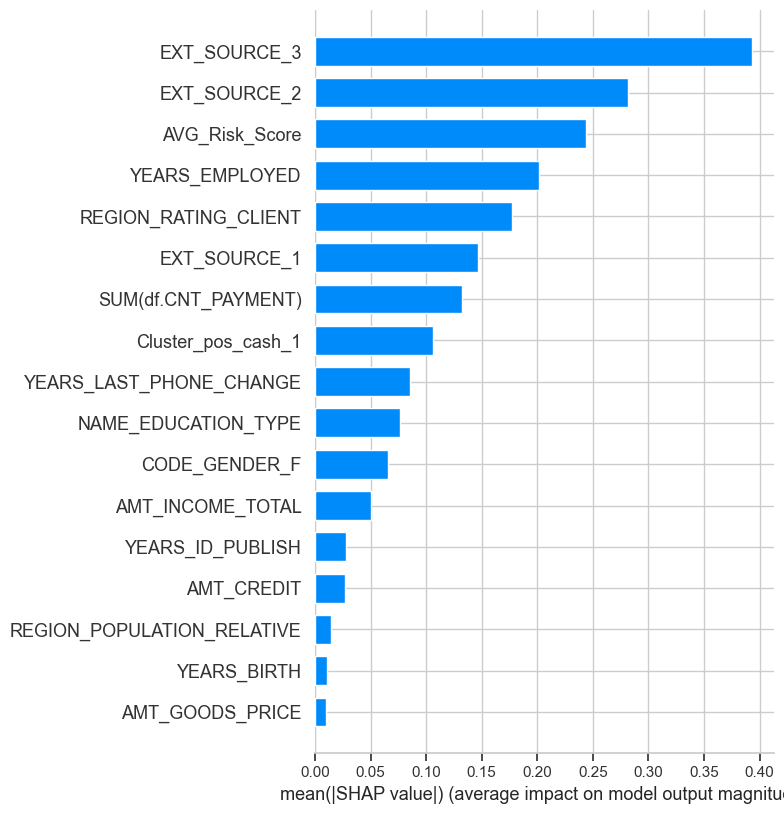

In [226]:
shap.summary_plot(shap_values, X_validation, plot_type='bar')

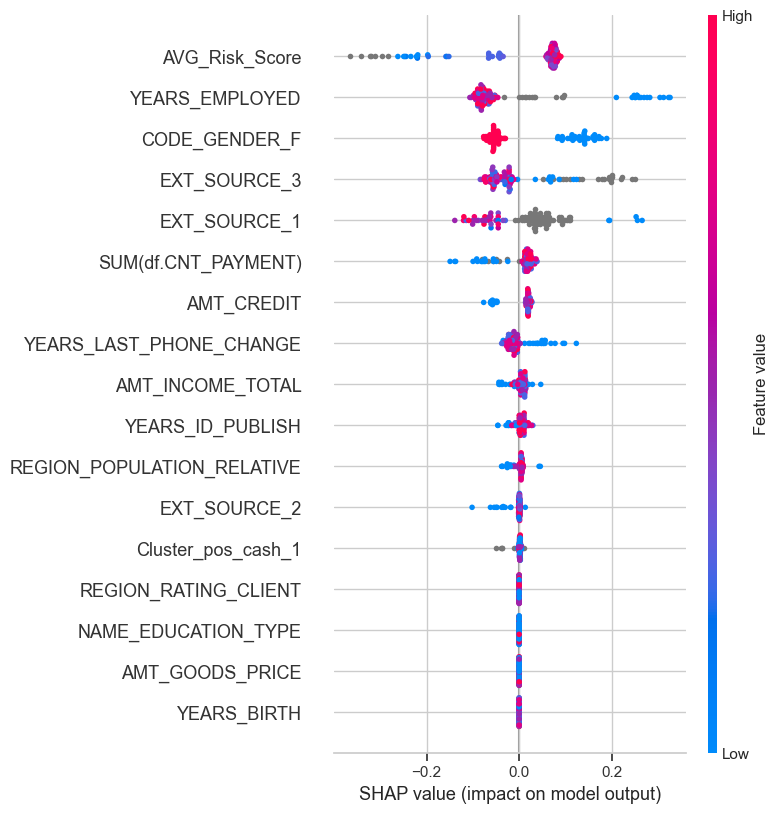

In [233]:
model = pipeline.named_steps['classifier']#.__class_

feature_names = X.columns   

X_validation_df = pd.DataFrame(X_validation, columns=feature_names)

explainer = shap.Explainer(model, X_validation_df)

background_sample = X_validation_df.sample(100, random_state=42)

shap_values = explainer.shap_values(background_sample)

shap.summary_plot(shap_values, features=background_sample)

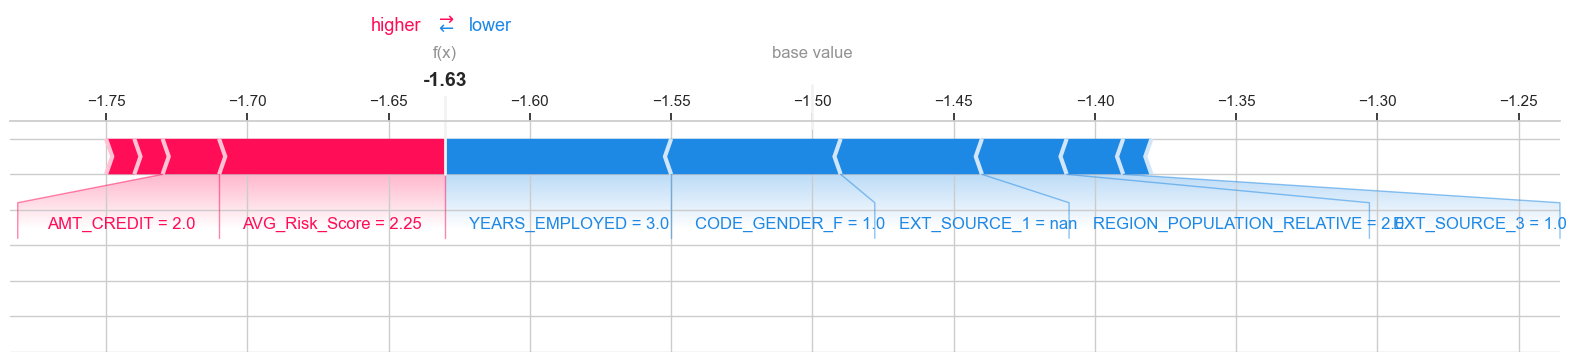

In [234]:
shap.plots.force(explainer.expected_value.round(2), shap_values[1].round(
    2), background_sample.iloc[0, :].round(2), matplotlib=True)

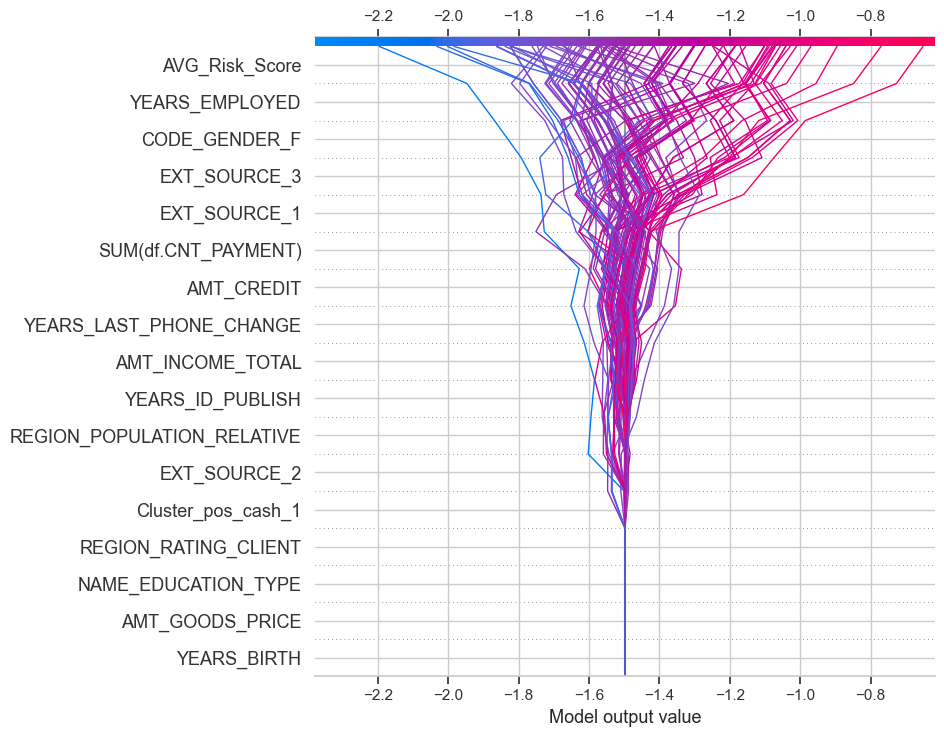

In [235]:
shap.decision_plot(explainer.expected_value, shap_values,
                   background_sample.columns)

# AVG Risk Score?
is quite empty...

In [237]:
selected_data.isna().sum()

YEARS_BIRTH                        0
REGION_RATING_CLIENT               0
EXT_SOURCE_2                     660
EXT_SOURCE_1                  173378
SUM(df.CNT_PAYMENT)            16454
AMT_GOODS_PRICE                  278
AMT_CREDIT                         0
YEARS_LAST_PHONE_CHANGE            1
NAME_EDUCATION_TYPE                0
AMT_INCOME_TOTAL                   0
AVG_Risk_Score                 18945
Cluster_pos_cash_1             19258
CODE_GENDER_F                      4
REGION_POPULATION_RELATIVE         0
YEARS_EMPLOYED                 55374
YEARS_ID_PUBLISH                   0
EXT_SOURCE_3                   60965
TARGET                             0
dtype: int64